In [1]:
import numpy as np

import torch
from torch.autograd import Variable
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

from tqdm.notebook import tqdm

import gym
from gym import spaces

from stable_baselines3 import A2C, PPO

import matplotlib.pyplot as plt
import seaborn as sns

import os

import copy

from stable_baselines3.common.callbacks import BaseCallback

In [2]:
%config InlineBackend.figure_format = "retina"
sns.set()

In [3]:
class Environment(gym.Env):

    def __init__(self, alpha=1., beta=0.2, tau=0.9, n_item=30, t_max=1000):
        super().__init__()
        
        self.action_space = spaces.Discrete(n_item)
        self.observation_space = spaces.Box(low=0.0, high=np.inf, shape=(n_item, 2))
        self.state = torch.zeros((n_item, 2))
        self.obs = torch.zeros((n_item, 2))
        self.n_item = n_item
        self.t_max = t_max
        self.t = 0
        
        self.log_tau = np.log(tau)
        self.alpha = alpha
        self.beta = beta

    def reset(self):
        self.state = torch.zeros((self.n_item, 2))
        self.obs = torch.zeros((self.n_item, 2))
        self.t = 0
        return self.obs

    def step(self, action):

        self.state[:, 0] += 1      # delta + 1 for all
        self.state[action, 0] = 0  # ...except for item shown
        self.state[action, 1] += 1 # increment number of presentation 
        
        done = self.t == self.t_max - 1
        
        view = self.state[:, 1] > 0
        delta = self.state[view, 0]
        rep = self.state[view, 1] - 1.
        
        forget_rate = self.alpha*(1-self.beta)**rep
        
        logp_recall = - forget_rate*delta
        above_thr = logp_recall > self.log_tau
        reward = torch.count_nonzero(above_thr).item() / self.n_item
            
        self.obs[view, 0] = torch.exp(-forget_rate*(delta+1))
        self.obs[view, 1] = forget_rate
        
        info = {}
        
        self.t += 1
        return self.obs, reward, done, info

In [4]:
class ProgressBarCallback(BaseCallback):
    """
    :param pbar: (tqdm.pbar) Progress bar object
    """
    def __init__(self, pbar, env, check_freq):
        super(ProgressBarCallback, self).__init__()
        self._pbar = pbar
        self.env = env
        self.check_freq = check_freq
        
        self.hist_rewards = []

    def _on_step(self):
        # Update the progress bar:
        self._pbar.n = self.num_timesteps
        self._pbar.update(0)
        
        # Evaluate
        if self.n_calls % self.check_freq == 0:
            obs = self.env.reset()
            rewards = []
            while True:
                action, _state = self.model.predict(obs, deterministic=True)
                obs, reward, done, info = self.env.step(action)

                rewards.append(reward)

                if done:
                    break
            self.hist_rewards.append(rewards)
            self._pbar.set_postfix({"average-reward": np.mean(rewards), "max-reward": np.max(rewards)})

# this callback uses the 'with' block, allowing for correct initialisation and destruction
class ProgressBarManager:
    def __init__(self, total_timesteps, env, check_freq): # init object with total timesteps
        self.pbar = None
        self.total_timesteps = total_timesteps
        self.env = copy.deepcopy(env)
        self.check_freq = check_freq
        self.pbar_callback = None
        
    def __enter__(self): # create the progress bar and callback, return the callback
        self.pbar = tqdm(total=self.total_timesteps)
        self.pbar_callback = ProgressBarCallback(self.pbar, self.env, self.check_freq)
        return self.pbar_callback

    def __exit__(self, exc_type, exc_val, exc_tb): # close the callback
        self.pbar.n = self.total_timesteps
        self.pbar.update(0)
        self.pbar.close()
    
    @property
    def hist_rewards(self):
        return self.pb_callback.hist_rewards

In [5]:
env = Environment(t_max=100, alpha=0.2, tau=0.9)
model = A2C('MlpPolicy', env, seed=123)

iterations = env.t_max*2000 
check_freq = 500

with ProgressBarManager(iterations, env, check_freq) as callback:
    model = model.learn(iterations, callback=callback)

  0%|          | 0/200000 [00:00<?, ?it/s]

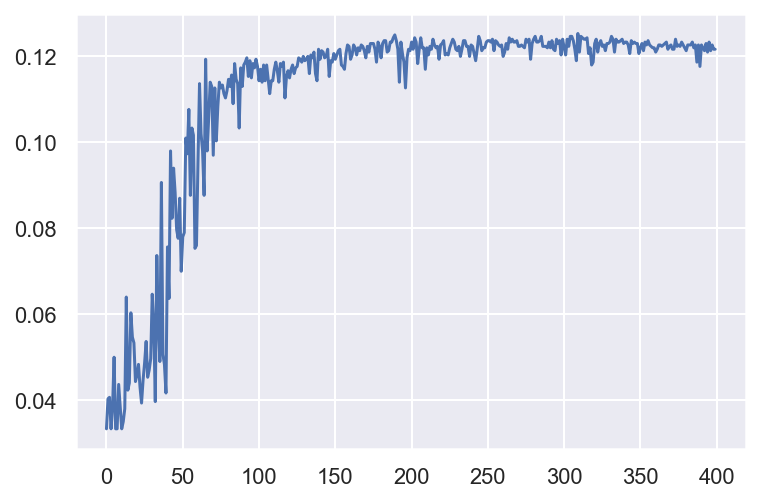

In [76]:
plt.plot([np.mean(r) for r in callback.hist_rewards])

In [77]:
rewards = []
actions = []

obs = env.reset()
while True:
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    
    rewards.append(reward)
    actions.append(action)
    
    if done:
        obs = env.reset()
        break

In [78]:
env.n_item

30

In [79]:
np.sum(rewards)

12.13333333333333

In [80]:
rewards = np.array(rewards)*env.n_item

(364.0, 1.7973313550928776)

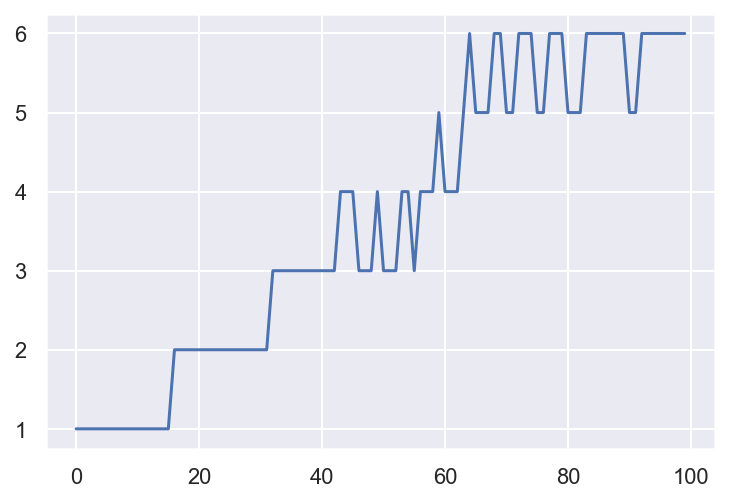

In [81]:
plt.plot(rewards)
np.sum(rewards), np.std(rewards)

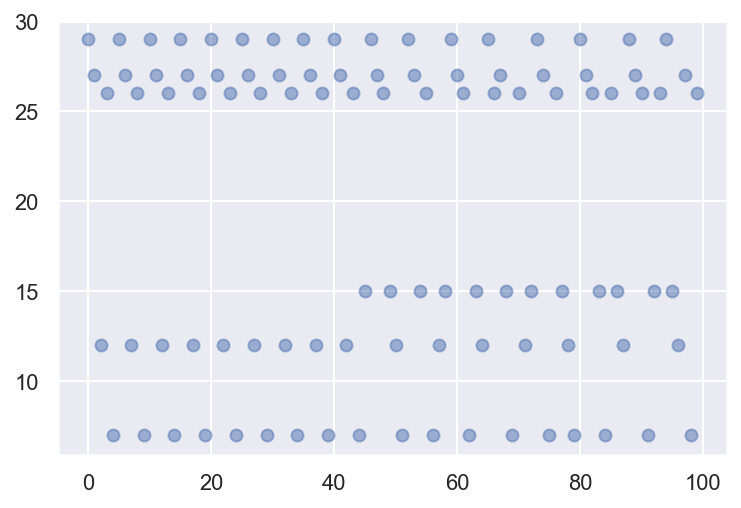

In [65]:
plt.scatter(np.arange(env.t_max), actions, alpha=0.5);

In [23]:
class Threshold:
    def __init__(self, tau, n_item):
        self.tau = tau
        self.n_item = n_item
        
    def act(self, obs):
        p_rec = obs[:, 0]

        view_under_thr = (0 < p_rec) * (p_rec <= self.tau)
        if torch.count_nonzero(view_under_thr).item() > 0:
            items = torch.arange(self.n_item)
            selec = items[view_under_thr]
            action = selec[torch.argmin(p_rec[view_under_thr])].item()
        else:
            n_seen = torch.count_nonzero(p_rec).item()
            max_item = self.n_item - 1
            action = np.min((n_seen, max_item))

        return action

In [24]:
tau = 0.9
n_item = 30
t_max = 100
env = Environment(t_max=t_max, alpha=0.2, tau=tau, n_item=n_item)
obs = env.reset()
policy = Threshold(tau=tau, n_item=n_item)
rewards = []
actions = []
while True:
    action = policy.act(obs)
    obs, reward, done, _ = env.step(action)
    rewards.append(reward)
    actions.append(action)
    if done:
        break

(360, 1.7492855684535902)

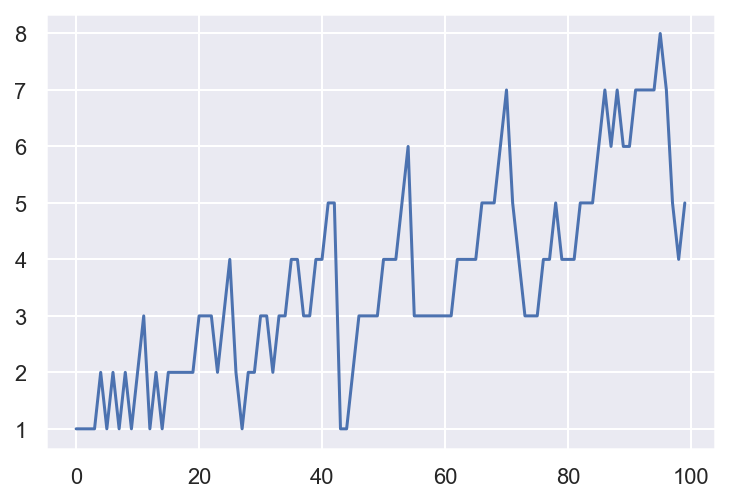

In [25]:
plt.plot(rewards)
np.sum(rewards), np.std(rewards)

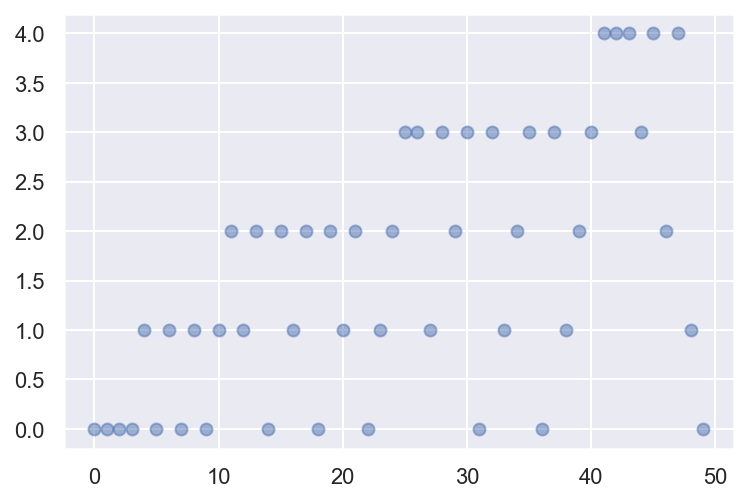

In [313]:
plt.scatter(np.arange(env.t_max), actions, alpha=0.5)